In [1]:
# install JAX using iPython magic command
%pip install --upgrade pip && pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_releases.html

import numpy as np
import numpy.linalg as nl
import scipy.linalg as sl
import scipy.integrate as si
import scipy.optimize as so
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.numpy.linalg as jnl
from jax.config import config
config.update("jax_enable_x64", True)

# import os
# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

%env XLA_PYTHON_CLIENT_PREALLOCATE=false

# make sure NVIDIA_VISIBLE_DEVICES is not 'none'
%env

Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html
Note: you may need to restart the kernel to use updated packages.
env: XLA_PYTHON_CLIENT_PREALLOCATE=false


{'PATH': '/opt/conda/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin',
 'HOSTNAME': 'jupyter-kcollins9-40ucmerced-2eedu',
 'NVIDIA_VISIBLE_DEVICES': 'GPU-5b523376-e638-4909-7b30-6f6000062da4',
 'JUPYTER_IMAGE_SPEC': 'localhost:30081/prp/jupyter-stack/scipy',
 'CPU_LIMIT': '8.0',
 'JUPYTERHUB_API_TOKEN': '<hidden>',
 'JUPYTERHUB_API_URL': 'http://hub:8081/hub/api',
 'JUPYTER_IMAGE': 'localhost:30081/prp/jupyter-stack/scipy',
 'JUPYTERHUB_BASE_URL': '/',
 'JUPYTERHUB_SERVICE_PREFIX': '/user/kcollins9@ucmerced.edu/',
 'JUPYTERHUB_USER': 'kcollins9@ucmerced.edu',
 'JUPYTERHUB_OAUTH_CALLBACK_URL': '/user/kcollins9@ucmerced.edu/oauth_callback',
 'JUPYTERHUB_ACTIVITY_URL': 'http://hub:8081/hub/api/users/kcollins9@ucmerced.edu/activity',
 'JUPYTERHUB_CLIENT_ID': 'jupyterhub-user-kcollins9%40ucmerced.edu',
 'JUPYTERHUB_HOST': '',
 'JUPYTERHUB_SERVER_NAME': '',
 'MEM_GUARANTEE': '8589934592',
 'MEM_LIMIT': '8589934592',
 'CPU_GUARANTEE':

<h1>Forward Problem</h1>

In [2]:
# size of spatial domain
L = 15.0  # originally 10, increased by 50%

# number of real space grid points (for plotting)
numx = 1025

# real space grid points (for plotting)
xvec = np.linspace(-L, L, numx)

# number of Fourier basis functions
# n = -numF to n = numF
numfour = 32  # 32

# vector of fourier mode indices
# fournvec = -numfour,...,0,...,numfour
fournvec = np.arange(-numfour, numfour + 1)

# matrix for converting Fourier representation to real space
fourtox = np.exp(1j * np.pi * np.outer(fournvec, xvec) / L) / np.sqrt(2 * L)

print('Shape fourtox:', fourtox.shape)

Shape fourtox: (65, 1025)


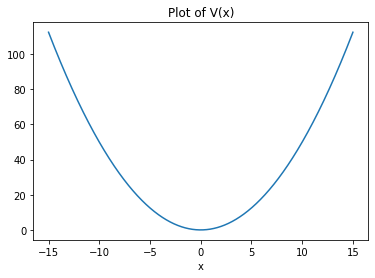

In [3]:
def v(z):
    # harmonic oscillator potential (should be exact for Chebyshev)
    return 0.5 * z**2
    # symmetric double well potential
    # return 2.5e-3 * (z**2 - 25)**2
    # asymmetric double well potential
    # c0 = 4.35; c1 = 9.40e-1; c2 = -3.56e-1; c3 = -4.66e-2
    # c4 = 1.46e-2; c5 = 6.76e-4; c6 = -1.26e-4; c7 = -5.43e-6
    # c8 = 4.12e-7; c9 = 1.65e-8
    # x = z + 0.8
    # return 0.5 * (c0 + c1*x + c2*x**2 + c3*x**3 + c4*x**4 + c5*x**5 + c6*x**6 + c7*x**7 + c8*x**8 + c9*x**9)
    # non-polynomial potentials
    # return np.sin(0.4 * z - 1)
    # return np.sin((0.5 * z)**2)
    # return 15 * (-np.cos(z) + np.sin((0.5 * z)**2 - 0.2 * z))
    # soft coulomb potential
    # return -1 / np.sqrt(z**2 + 0.25)

# true potential on real space grid (for plotting)
vxvec = v(xvec)

# plot true potential
plt.plot(xvec, vxvec)
plt.title('Plot of V(x)')
plt.xlabel('x')
plt.show()

In [4]:
# compute the potential operator matrix, vmat

vtoeptrue = []
for thisfourn in range(2 * numfour + 1):
    def intgrnd(x):
        return v(x) * np.exp(-1j * np.pi * thisfourn * x / L) / (2 * L)
    def rintgrnd(x):
        return intgrnd(x).real
    def iintgrnd(x):
        return intgrnd(x).imag
    vtoeptrue.append(si.quad(rintgrnd, -L, L, limit=100)[0] + 1j * si.quad(iintgrnd, -L, L, limit=100)[0])

vtoeptrue = jnp.array(vtoeptrue)
print('Shape vtoeptrue', vtoeptrue.shape)

vmattrue = sl.toeplitz(r=vtoeptrue, c=np.conj(vtoeptrue))

print('Shape vmattrue:', vmattrue.shape)

Shape vtoeptrue (65,)
Shape vmattrue: (65, 65)


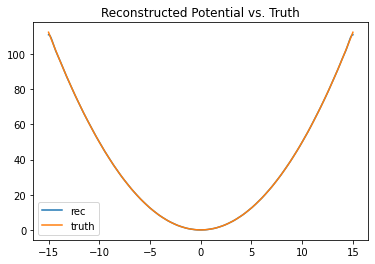

0.012198398680964478


In [5]:
# reconstruct the real space potential from the potential
# operator matrix

# at this point, "vtoeptrue" contains Fourier coefficients
# for modes 0, ..., 2*N
# let us convert this into information on modes -N, ..., N
# also we need a slight renormalization to make this a Fourier
# coefficient
# with respect to our ***orthonormal*** Fourier basis
vfourtrue = np.sqrt(2*L) * np.concatenate([np.flipud(vtoeptrue[1:(numfour + 1)]).conj(), vtoeptrue[:(numfour + 1)]])
vtruerec = vfourtrue @ fourtox

plt.plot(xvec, np.real(vtruerec), label='rec')
plt.plot(xvec, vxvec, label='truth')
plt.title('Reconstructed Potential vs. Truth')
plt.legend()
plt.show()

print(np.mean(np.square(np.abs(vtruerec - vxvec))))

In [6]:
# define initial states and transform to Fourier basis

def psi0_0(x):
    return 10 * np.exp(-((x + 3) / 4)**2) * (2.0 / np.pi)**0.25
    # return 10 * np.exp(-((x + 3) / 2)**2) * (2.0 / np.pi)**0.25

def psi0_1(x):
    return np.exp(-((x - 3) / 4)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-((x - 3) / 2)**2) * (2.0 / np.pi)**0.25

def psi0_2(x):
    # return np.exp(-x**2) * (2.0 / np.pi)**0.25
    return np.exp(-((x - 8) / 4)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-((x - 6)/4)**2) * (2.0 / np.pi)**0.25

def psi0_3(x):
    # a weird non-symmetric wavefunction
    # return np.abs(np.sin((0.15*x - 0.5)**2))
    return np.exp(-((x + 8) / 4)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-((x + 6)/4)**2) * (2.0 / np.pi)**0.25

def psi0_4(x):
    return np.exp(-((x - 12) / 4)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-(x - 11)**2) * (2.0 / np.pi)**0.25

def psi0_5(x):
    return np.exp(-((x + 12) / 4)**2) * (2.0 / np.pi)**0.25
    # return np.exp(-(x + 11)**2) * (2.0 / np.pi)**0.25


# function for normalizing initial wave functions and transforming them to the Fourier representation

def mka0(psi0fn):
    # compute psi0 normalization term
    psi0fn_prob_intgrnd = lambda x: np.abs(psi0fn(x)) ** 2
    psi0fn_norm = np.sqrt(si.quad(psi0fn_prob_intgrnd, -L, L)[0])

    # normalized psi function (for integration)
    norm_psi0fn = lambda x: psi0fn(x) / psi0fn_norm

    # compute the Fourier representation of psi0fn
    a0raw = []
    for thisfourn in range (numfour + 1):
        def intgrnd(x):
            return norm_psi0fn(x) * np.exp(-1j * np.pi * thisfourn * x / L) / np.sqrt(2 * L)
        def rintgrnd(x):
            return intgrnd(x).real
        def iintgrnd(x):
            return intgrnd(x).imag
        a0raw.append(si.quad(rintgrnd, -L, L, limit=100)[0] + 1j * si.quad(iintgrnd, -L, L, limit=100)[0])

    a0 = np.concatenate([np.conjugate(np.flipud(a0raw[1:])), a0raw])

    a0 = jnp.array(a0)

    normpsi0x = norm_psi0fn(xvec)

    return a0, normpsi0x


l2 error psi0_0: 7.476210590807997e-05
l-infinity error psi0_0: 3.137317008559103e-05
l2 error psi0_1: 7.476210590808388e-05
l-infinity error psi0_1: 3.1373170085563275e-05
l2 error psi0_2: 0.02843592889688725
l-infinity error psi0_2: 0.01129795852635211
l2 error psi0_3: 0.028435928896887255
l-infinity error psi0_3: 0.01129795852635211


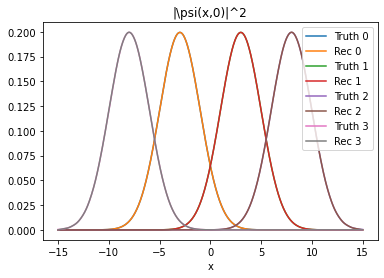

In [7]:
# compute vector of initial states

# pick initial un-normalized wave functions
psi0fnvec = [psi0_0, psi0_1, psi0_2, psi0_3]  # [psi0_0, psi0_1, psi0_2, psi0_3, psi0_4, psi0_5]

a0vec = []
normpsi0xvec = []
normpsi0recxvec = []
for thispsi0fn in psi0fnvec:
    tempa0, tempnormpsi0x = mka0(thispsi0fn)
    a0vec.append(tempa0)
    normpsi0xvec.append(tempnormpsi0x)
    normpsi0recxvec.append(tempa0 @ fourtox)


# check if reconstructed Fourier representation is close to truth
for i in range(len(normpsi0xvec)):
    print(f'l2 error psi0_{i}:', nl.norm(normpsi0xvec[i] - normpsi0recxvec[i]))
    print(f'l-infinity error psi0_{i}:', np.max(np.abs(normpsi0xvec[i] - normpsi0recxvec[i])))
    # plot |\psi(x,0)|^2
    plt.plot(xvec, np.abs(normpsi0xvec[i])**2, label=f"Truth {i}")
    plt.plot(xvec, np.abs(normpsi0recxvec[i])**2, label=f"Rec {i}")

plt.title('|\psi(x,0)|^2')
plt.xlabel('x')
plt.legend()
plt.show()

---
**Forward Propagation**

In [8]:
# Eigendecomposition of Hamiltonian

# kinetic operator in the Fourier representation
# (this is constant for a given system)
kmat = np.diag(np.arange(-numfour, numfour + 1) ** 2 * np.pi ** 2 / (2 * L ** 2))

# Hamiltonian operator in the Fourier representation
hmattrue = kmat + vmattrue

# check if the Hamiltonian matrix is Hermitian
print('hmattrue Hermitian check (should be close to zero):', nl.norm(hmattrue - hmattrue.T.conj()), sep='\n')

# eigen-decomposition of the Hamiltonian matrix
spctrue, stttrue = jnl.eigh(hmattrue)

# check if the decomposition diagonalizes the
# Hamiltonian matrix
# if this is close to zero then
# hmat = states @ np.diag(spec) @ np.conj(states).T
print('hmattrue diagonalized check (should be close to zero):', nl.norm(hmattrue @ stttrue - stttrue @ np.diag(spctrue)), sep='\n')

# check if the eigenstates are unitary
print('stttrue unitary check (should be close to zero):', nl.norm(stttrue @ stttrue.T.conj() - np.eye(2 * numfour + 1)), sep='\n')

hmattrue Hermitian check (should be close to zero):
0.0
hmattrue diagonalized check (should be close to zero):
9.770256348336455e-13
stttrue unitary check (should be close to zero):
1.9640078542463594e-14


[0.5 1.5 2.5 3.5 4.5 5.5]


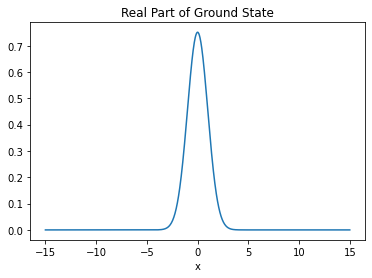

Quick normalization check (should be close to 1):
1.0000000000000022
Accurate normalization check (should be close to 1):
1.0000000000000022


In [9]:
# plot ground state of Eigendecomposition

# find indices that sort eigenvalues
ordering = jnp.argsort(spctrue)

# print the first few eigenvalues
print(spctrue[ordering[:6]])

# pick out and plot real part of the ground state
groundstate = ordering[0]
wavefn = stttrue[:, groundstate] @ fourtox
plt.plot(xvec, np.real(wavefn))
plt.title('Real Part of Ground State')
plt.xlabel('x')
plt.show()

# quick and dirty check of normalization
print('Quick normalization check (should be close to 1):', np.sum(np.abs(wavefn)**2 * (xvec[1]-xvec[0])), sep='\n')

# this should be a more accurate check of the ground state
# wave functions' normalization
print('Accurate normalization check (should be close to 1):', si.trapezoid(np.abs(wavefn)**2, xvec), sep='\n')

In [10]:
# Propagate

# set time-step size
dt = 1e-2  # 1e-2

# set number of time steps
# trajectory length is numts + 1 (initial state + numts steps)
numts = 20  # 20

# compute propagator matrix
propatrue = stttrue @ jnp.diag(jnp.exp(-1j * spctrue * dt)) @ stttrue.conj().T

amattruevec = []
# propagate system starting from initial "a" state
for thisa0 in a0vec:
    tempamat = [thisa0.copy()]
    for i in range(numts):
        tempamat.append(propatrue @ tempamat[-1])

    amattruevec.append(tempamat)


amattruevec = jnp.array(amattruevec)

print('Shape amattrue:', amattruevec.shape)

print('Done propagating')

Shape amattrue: (4, 21, 65)
Done propagating


In [11]:
# check if system's state remains normalized for the propagation

psimattruevec = amattruevec @ fourtox
print('Shape psimattrue:', psimattruevec.shape)

probmattruevec = np.abs(psimattruevec) ** 2
print('Shape probmattrue:', probmattruevec.shape)

normmattruevec = si.trapezoid(probmattruevec, xvec)
print('Shape normmattrue:', normmattruevec.shape)

# average deviation from 1
print('Average deviation from 1 of propgated wave function:', np.mean(np.abs(normmattruevec - 1.0)), sep='\n')

Shape psimattrue: (4, 21, 1025)
Shape probmattrue: (4, 21, 1025)
Shape normmattrue: (4, 21)
Average deviation from 1 of propgated wave function:
1.0166187388560302e-05


---
<h1>Inverse Problem</h1>

In [12]:
# used for constructing Toeplitz matrix from a vector setup
# like jnp.concatenate([jnp.flipud(row.conj()), row[1:]])

numtoepelms = 2 * numfour + 1
aa = (-1) * np.arange(0, numtoepelms).reshape(numtoepelms, 1)
bb = [np.arange(numtoepelms - 1, 2 * numtoepelms - 1)]
toepindxmat = np.array(aa + bb)
print(toepindxmat.shape)

(65, 65)


In [13]:
# check if index method makes same vmat
# should be close to 0

print(nl.norm(vmattrue - np.concatenate([np.flipud(np.conj(vtoeptrue)), vtoeptrue[1:]])[toepindxmat]))

0.0


In [14]:
# make |\psi(t)|^2 training data in the Fourier representation

# compute "beta" from "a"
# correlate only works with 1D vectors
betamatvec = []
for thisamattrue in amattruevec:
    tempbetamat = []
    for thisavectrue in thisamattrue:
        tempbetamat.append(jnp.correlate(thisavectrue, thisavectrue, 'same'))

    betamatvec.append(jnp.array(tempbetamat))

betamatvec = jnp.array(betamatvec) / jnp.sqrt(2 * L)


print('Shape betamattruevec:', betamatvec.shape)
print('Shape probmattruevec:', probmattruevec.shape)

probmatrecvec = betamatvec @ fourtox
print('Shape probmatrecvec @ fourtox:', probmatrecvec.shape)

print('l2 error probmatrecvec:', jnl.norm(probmattruevec - probmatrecvec, axis=(1, 2)))
print('l-inf error probmatrecvec:', jnp.max(jnp.abs(probmattruevec - probmatrecvec), axis=(1, 2)))

Shape betamattruevec: (4, 21, 65)
Shape probmattruevec: (4, 21, 1025)
Shape probmatrecvec @ fourtox: (4, 21, 1025)
l2 error probmatrecvec: [3.65797364e-06 3.65797364e-06 3.45528496e-03 3.45528496e-03]
l-inf error probmatrecvec: [1.24992128e-07 1.24992128e-07 9.99758955e-05 9.99758955e-05]


In [15]:
# objective function

def ampsqobject(theta, verbose=False):
    # theta is a vector containing the concatenation
    # of real and imaginary parts of vmat
    # its size should be 2 * numtoepelms - 1 = 4 * numfour + 1

    # to use theta we need to first recombine the real
    # and imaginary parts into a vector of complex values
    vtoephatR = theta[:numtoepelms]
    vtoephatI = jnp.concatenate((jnp.array([0.0]), theta[numtoepelms:]))
    vtoephat = vtoephatR + 1j * vtoephatI

    if verbose:
        print('l2 error vtoephat:', jnl.norm(vtoephat - vtoeptrue))

    # construct vmathat from complex toeplitz vector
    vmathat = jnp.concatenate([jnp.flipud(jnp.conj(vtoephat)), vtoephat[1:]])[toepindxmat]

    # Construct Hamiltonian matrix
    hmathat = kmat + vmathat

    if verbose:
        # check if hmat is Hermitian
        print('hmat hermitian? (should be close to 0):', jnl.norm(hmathat - hmathat.T.conj()), sep='\n')
        print('l2 error hmat:', jnl.norm(hmathat - hmattrue))

    # eigen-decomposition of the Hamiltonian matrix
    spchat, stthat = jnl.eigh(hmathat)

    if verbose:
        # check if the decomposition diagonalizes hmat
        # if this is close to zero then
        # hmat = states @ np.diag(spec) @ np.conj(states).T
        print('hmathat diagonalized? (should be close to 0):', jnl.norm(hmathat @ stthat - stthat @ jnp.diag(spchat)), sep='\n')

        # check if stt is unitary
        print('stthat unitary? (should be close to 0):', jnl.norm(stthat @ stthat.T.conj() - jnp.eye(2 * numfour + 1)), sep='\n')

        print('l2 error spchat:', jnl.norm(spchat - spctrue))
        print('l2 error stthat:', jnl.norm(stthat - stttrue))

        print('|| vmattrue - vmathat || = ', jnl.norm(vmattrue - vmathat))

    # compute propagator matrix
    propahat = stthat @ jnp.diag(jnp.exp(-1j * spchat * dt)) @ stthat.conj().T

    rtnobj = 0.0
    for r in range(len(a0vec)):
        thisahat = a0vec[r].copy()
        thisbetahatmat = [jnp.correlate(thisahat, thisahat, 'same') / jnp.sqrt(2 * L)]

        if verbose:
            print('')
            print('l2 error thisavec:', jnl.norm(thisahat - amattruevec[r, 0]))
            print('l2 error tempbetamat[-1]:', jnl.norm(thisbetahatmat[-1] - betamatvec[r, 0]))

        # propagate system starting from initial "a" state
        for i in range(numts):
            # propagate the system one time-step
            thisahat = (propahat @ thisahat)

            # calculate the amp^2
            thisbetahatmat.append(jnp.correlate(thisahat, thisahat, 'same') / jnp.sqrt(2 * L))

            if verbose:
                # if i % 1 == 0:
                if i % 10 == 0:
                    print('l2 error thisavec:', jnl.norm(thisahat - amattruevec[r, i+1]))
                    print('l2 error tempbetamat[-1]:', jnl.norm(thisbetahatmat[-1] - betamatvec[r, i+1]))

        # compute objective functions
        tempresid = jnp.array(thisbetahatmat) - betamatvec[r]
        thisobj = 0.5 * jnp.sum(jnp.abs(tempresid)**2)
        rtnobj += thisobj

        if verbose:
            print('')
            print('Shape tempbetamat:', jnp.shape(thisbetahatmat))
            print('l2 error tempbetamat:', jnl.norm(tempresid))
            print('thisobj:', thisobj)
            print('')

    return rtnobj

In [16]:
# true potential in a form that can be tested in objective

thetatrue = jnp.concatenate((jnp.real(vtoeptrue), jnp.imag(vtoeptrue[1:])))

print('Shape vfourcat:', thetatrue.shape)

print(nl.norm(thetatrue[:numtoepelms] + 1j * jnp.concatenate((jnp.array([0.0]), thetatrue[numtoepelms:])) - vtoeptrue))

Shape vfourcat: (129,)
0.0


In [17]:
# check objective with true potential
print('Objective:', ampsqobject(thetatrue, verbose=True))

l2 error vtoephat: 0.0
hmat hermitian? (should be close to 0):
0.0
l2 error hmat: 0.0
hmathat diagonalized? (should be close to 0):
9.770256348336455e-13
stthat unitary? (should be close to 0):
1.9640078542463594e-14
l2 error spchat: 0.0
l2 error stthat: 0.0
|| vmattrue - vmathat || =  0.0

l2 error thisavec: 0.0
l2 error tempbetamat[-1]: 0.0
l2 error thisavec: 0.0
l2 error tempbetamat[-1]: 0.0
l2 error thisavec: 0.0
l2 error tempbetamat[-1]: 0.0

Shape tempbetamat: (21, 65)
l2 error tempbetamat: 0.0
thisobj: 0.0


l2 error thisavec: 0.0
l2 error tempbetamat[-1]: 0.0
l2 error thisavec: 0.0
l2 error tempbetamat[-1]: 0.0
l2 error thisavec: 0.0
l2 error tempbetamat[-1]: 0.0

Shape tempbetamat: (21, 65)
l2 error tempbetamat: 0.0
thisobj: 0.0


l2 error thisavec: 0.0
l2 error tempbetamat[-1]: 0.0
l2 error thisavec: 0.0
l2 error tempbetamat[-1]: 0.0
l2 error thisavec: 0.0
l2 error tempbetamat[-1]: 0.0

Shape tempbetamat: (21, 65)
l2 error tempbetamat: 0.0
thisobj: 0.0


l2 error thisavec: 0.

In [18]:
# jit ampsqobject
jitampsqobject = jax.jit(ampsqobject)

In [19]:
# complie and test jitampsqobject
print(jitampsqobject(thetatrue))

6.067470301657784e-32


In [20]:
# JAX grad of the objective
gradprobobj = jax.jit(jax.grad(jitampsqobject))

In [21]:
# check grad of objective with true potential
print(jnl.norm(gradprobobj(thetatrue)))

2.0877870500487004e-18


---
---
**Initialize with perturbed truth**

In [22]:
# seed = 1234  # set to None for random initialization
# thetatrub = thetatrue.copy()
# # thetatrub += 0.2 * np.random.default_rng(seed).normal(size=len(thetatrub))
# thetatrub += 2 * np.random.default_rng(seed).normal(size=len(thetatrub))
#
# thetatrub = jnp.array(thetatrub)

In [23]:
# print(jitampsqobject(thetatrub))
# print(nl.norm(gradprobobj(thetatrub)))

In [24]:
# rslttrubjaxgrad = so.minimize(jitampsqobject, thetatrub, jac=gradprobobj, tol=1e-12, options={'maxiter': 1000, 'disp': True, 'gtol': 1e-15}).x
#
# # rslttrubjaxgrad = so.minimize(jitampsqobject, thetatrub, jac=gradprobobj, options={'maxiter': 2000, 'disp': True}).x
#
# # rslttrubjaxgrad = so.minimize(jitampsqobject, thetatrue, jac=gradprobobj, tol=1e-12, options={'maxiter': 3000, 'disp': True, 'gtol': 1e-15}).x

In [25]:
# print(jitampsqobject(rslttrubjaxgrad))
# print(nl.norm(gradprobobj(rslttrubjaxgrad)))

In [26]:
# vtoeplearnR = rslttrubjaxgrad[:numtoepelms]
# vtoeplearnI = jnp.concatenate((jnp.array([0.0]), rslttrubjaxgrad[numtoepelms:]))
# vtoeplearn = vtoeplearnR + 1j * vtoeplearnI
#
# print(nl.norm(vtoeplearn - vtoeptrue))
# print(np.max(np.abs(vtoeplearn - vtoeptrue)))
#
# vlearnfour = np.sqrt(2 * L) * np.concatenate([np.conjugate(np.flipud(vtoeplearn[1:(numfour + 1)])), vtoeplearn[:(numfour + 1)]])
# vlearnrec = vlearnfour @ fourtox

In [27]:
# # plot learned v against true v
#
# vtoepinitR = thetatrub[:numtoepelms]
# vtoepinitI = jnp.concatenate((jnp.array([0.0]), thetatrub[numtoepelms:]))
# vtoepinit = vtoepinitR + 1j * vtoepinitI
#
# vinitfour = np.sqrt(2 * L) * np.concatenate([np.conjugate(np.flipud(vtoepinit[1:(numfour + 1)])), vtoepinit[:(numfour + 1)]])
# vinitrec = vinitfour @ fourtox
#
# plt.plot(xvec, jnp.real(vlearnrec), '.-', label='learned')
# plt.plot(xvec, vxvec, label='truth')
# plt.plot(xvec, jnp.real(vinitrec), label='init')
# plt.xlabel('x')
# plt.title('V init vs. V learned vs. V true')
# plt.legend()
# plt.show()

---
---
**Initialize with random coefficients close to zero**

In [28]:
seed = 1234  # set to None for random initialization
# thetarnd = np.random.default_rng(seed).uniform(low=-5.0, high=5.0, size=thetatrue.shape)
thetarnd = 0.001 * np.random.default_rng(seed).normal(size=thetatrue.shape)


thetarnd = jnp.array(thetarnd)

In [29]:
jaxgradlog = []
def jax_grad_loger(theta):
    thisgrad = gradprobobj(theta)
    jaxgradlog.append(thisgrad)
    return thisgrad

# print(jax_grad_loger(thetatrue))

jaxobjectlog = []
def jax_object_loger(theta):
    thisobject = jitampsqobject(theta)
    jaxobjectlog.append(thisobject)
    return thisobject

# print(jax_object_loger(thetatrue))

In [30]:
jaxgradlog = []
jaxobjectlog = []
rsltjaxthetarnd = so.minimize(jax_object_loger, thetarnd, jac=jax_grad_loger, tol=1e-12, options={'maxiter': 1000, 'disp': True, 'gtol': 1e-15}).x

# rsltjaxthetarnd = so.minimize(jitampsqobject, thetarnd, jac=gradprobobj, tol=1e-12, options={'maxiter': 1000, 'disp': True, 'gtol': 1e-15}).x


         Current function value: 0.000003
         Iterations: 1000
         Function evaluations: 1013
         Gradient evaluations: 1013


(1013, 129)
(1013,)
0.0036963383770809697
0.00369633837708097


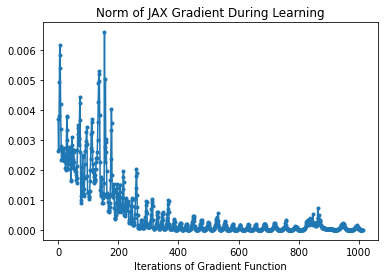

In [31]:
print(np.shape(jaxgradlog))
print(nl.norm(jaxgradlog, axis=1).shape)

print(nl.norm(gradprobobj(thetarnd)))
print(nl.norm(jaxgradlog, axis=1)[0])

plt.plot(nl.norm(jaxgradlog, axis=1), '.-')
plt.title('Norm of JAX Gradient During Learning')
plt.xlabel('Iterations of Gradient Function')
plt.show()


(1013,)


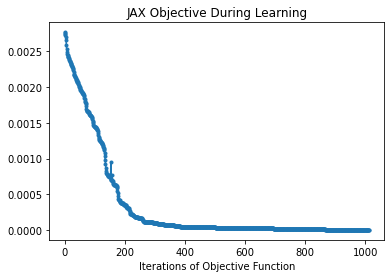

In [32]:
print(np.shape(jaxobjectlog))

plt.plot(jaxobjectlog, '.-')
plt.title('JAX Objective During Learning')
plt.xlabel('Iterations of Objective Function')
plt.show()

In [33]:
# learned concatenated vmat to learned complex vmat
jaxvtoeplearnR = rsltjaxthetarnd[:numtoepelms]
jaxvtoeplearnI = jnp.concatenate((jnp.array([0.0]), rsltjaxthetarnd[numtoepelms:]))
jaxvtoeplearn = jaxvtoeplearnR + 1j * jaxvtoeplearnI

print('l2 error of learned vmat:', nl.norm(jaxvtoeplearn - vtoeptrue), sep='\n')
print('l-inf error of learned vmat:', np.max(np.abs(jaxvtoeplearn - vtoeptrue)), sep='\n')

l2 error of learned vmat:
39.595305386766874
l-inf error of learned vmat:
37.501603836789215


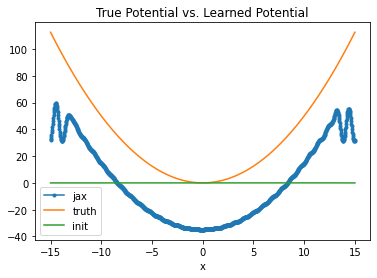

In [34]:
# plot learned vs true

# learned complex vmat to learned v
jaxvlearnfour = np.sqrt(2 * L) * np.concatenate([np.conjugate(np.flipud(jaxvtoeplearn[1:(numfour + 1)])), jaxvtoeplearn[:(numfour + 1)]])
jaxvlearnrec = jaxvlearnfour @ fourtox

# init concatenated vmat to init complex vmat
vtoepinitR = thetarnd[:numtoepelms]
vtoepinitI = jnp.concatenate((jnp.array([0.0]), thetarnd[numtoepelms:]))
vtoepinit = vtoepinitR + 1j * vtoepinitI
# init complex vmat to init v
vinitfour = np.sqrt(2 * L) * np.concatenate([np.conjugate(np.flipud(vtoepinit[1:(numfour + 1)])), vtoepinit[:(numfour + 1)]])
vinitrec = vinitfour @ fourtox

plt.plot(xvec, jnp.real(jaxvlearnrec), '.-', label='jax')
plt.plot(xvec, vxvec, label='truth')
plt.plot(xvec, jnp.real(vinitrec), label='init')
plt.xlabel('x')
plt.title('True Potential vs. Learned Potential')
plt.legend()
plt.show()

0.0
-11.337890625
35.034576546926765


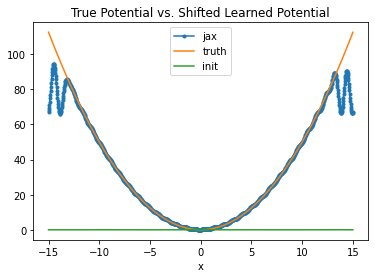

l2 error of jax potential:
268.4899386370853
l2 error of trimmed result:
12.468666181495212
l-inf error of trimmed result:
0.3517501295485507


In [35]:
zeroindex = len(xvec) // 2
print(xvec[zeroindex])

print(xvec[125])

jaxdiff = np.abs(vxvec[zeroindex] - jnp.real(jaxvlearnrec)[zeroindex])
print(jaxdiff)

plt.plot(xvec, jnp.real(jaxvlearnrec) + jaxdiff, '.-', label='jax')
plt.plot(xvec, vxvec, label='truth')
plt.plot(xvec, jnp.real(vinitrec), label='init')
plt.xlabel('x')
plt.title('True Potential vs. Shifted Learned Potential')
plt.legend()
plt.show()

print('l2 error of jax potential:', nl.norm(jnp.real(jaxvlearnrec) + jaxdiff - vxvec), sep='\n')
print('l2 error of trimmed result:', nl.norm(jnp.real(jaxvlearnrec)[125:-125] + jaxdiff - vxvec[125:-125]), sep='\n')
print('l-inf error of trimmed result:', np.mean(np.abs(jnp.real(jaxvlearnrec)[125:-125] + jaxdiff - vxvec[125:-125])), sep='\n')

---
<h1>Adjoint Method</h1>

\begin{equation*}
%
\rho_j^r
& = \frac{1}{\sqrt{2 L}} \sum_{k=-F}^F a_{k + j}^r \overline{a}_k^r
%
\end{equation*}

``rho = [jnp.correlate(thisa0, thisa0, 'same') / jnp.sqrt(2 * L)]``


\begin{equation*}
%
M_{j, \ell}^r = \overline{a_{\ell - j}^r}
%
\end{equation*}

\begin{equation*}
%
P_{j, \ell}^r = a_{\ell + j}^r
%
\end{equation*}

In [36]:
def mk_M_and_P(avec):
    halflen = len(avec) // 2
    padavec = jnp.concatenate((jnp.zeros(halflen), jnp.array(avec), jnp.zeros(halflen)))

    rawmat = []
    for j in range(2 * halflen + 1):
        rawmat.append(padavec[2 * halflen - j:4 * halflen + 1 - j])

    Mmat = jnp.conjugate(jnp.array(rawmat))
    Pmat = jnp.flipud(jnp.array(rawmat))

    return Mmat, Pmat

In [37]:
jit_mk_M_and_P = jax.jit(mk_M_and_P)

In [38]:
# direct computation of sum to check if M and P
# matrices are correct

# testa = [1, 2, 3, 4, 5]  # [1 + 0.5j, 2 + 1.0j, 3 + 1.5j, 4 + 2.0j, 5 + 2.5j]
#
# testM, testP = jit_mk_M_and_P(testa)
# print('M:', testM, 'P:', testP, sep='\n')
#
# # print(testM + testP)
# print(np.sum(testM + testP, axis=1))

# testhalflen = len(testa) // 2
# testdeltavec = []
# for j in np.arange(-testhalflen, testhalflen+1):
#     thissum = 0
#     for ell in np.arange(-testhalflen, testhalflen+1):
#         # print('j:', j)
#         # print('ell:', ell)
#         if np.abs(ell-j) > testhalflen:
#             am = 0
#         else:
#             am = testa[testhalflen + ell - j]
#         if np.abs(ell+j) > testhalflen:
#             ap = 0
#         else:
#             ap = testa[testhalflen + ell + j]
#
#         # print('am:', am)
#         # print('ap:', ap)
#         thissum += np.conjugate(am) + ap
#
#     testdeltavec.append(thissum)
#
# print(testdeltavec)
#
# # print(testM + testP)
# print(np.sum(testM + testP, axis=1))

---

\begin{equation*}
%
\lambda^T
= \frac{1}{\sqrt{2 L}} \left[ \left( M^T \right)^\dagger \left( \rho^T - \beta^T \right) + \overline{\left( P^T \right)^\dagger \left( \rho^T - \beta^T \right)} \right]
%
\end{equation*}

\begin{equation*}
%
\lambda^r
= \frac{1}{\sqrt{2 L}} \left[ \left( M^r \right)^\dagger \left( \rho^r - \beta^r \right) + \overline{\left( P^r \right)^\dagger \left( \rho^r - \beta^r \right)} \right] +
\left[ e^{ -i \hat{H} \Delta t} \right]^\dagger \lambda^{r+1}
%
\end{equation*}

\begin{equation*}
%
\frac{\partial L}{\partial \hat{\theta}}
= \mathfrak{R}
\left< \lambda^{r+1},
\left. \frac{\partial}{\partial \Upsilon} e^\Upsilon \right|_{\Upsilon = -i \hat{H} \Delta t}
\left( -i \Delta t \right) \hat{a}^r
\right>
= \mathfrak{R} - \sum_{r=0}^{T-1}
\left( \lambda^{r+1} \right)^\dagger
\left. \frac{\partial}{\partial \Upsilon} e^\Upsilon \right|_{\Upsilon = -i \hat{H} \Delta t}
\left( -i \Delta t \right) \hat{a}^r
%
\end{equation*}

In [63]:
def adjgrads(theta):
    # to use theta we need to first recombine the real
    # and imaginary parts into a vector of complex values
    vtoephatR = theta[:numtoepelms]
    vtoephatI = jnp.concatenate((jnp.array([0.0]), theta[numtoepelms:]))
    vtoephat = vtoephatR + 1j * vtoephatI
    # print('Shape vtoephat:', vtoephat.shape)

    # construct vmathat from complex toeplitz vector
    vmathat = jnp.concatenate([jnp.flipud(jnp.conj(vtoephat)), vtoephat[1:]])[toepindxmat]

    # Construct Hamiltonian matrix
    hmathat = kmat + vmathat

    # eigen-decomposition of the Hamiltonian matrix
    spchat, stthat = jnl.eigh(hmathat)

    # compute propagator matrix
    propahat = stthat @ jnp.diag(jnp.exp(-1j * spchat * dt)) @ stthat.conj().T
    proplam = jnp.transpose(jnp.conjugate(propahat))

    # forward propagation
    ahatmatvec = []
    lammatvec = []
    for r in range(len(a0vec)):
        # propagate system starting from initial "a" state
        thisahatmat = [a0vec[r].copy()]
        thisrhomat = [jnp.correlate(thisahatmat[0], thisahatmat[0], 'same') / jnp.sqrt(2 * L)]
        thispartlammat = [jnp.zeros(numtoepelms, dtype=complex)]

        for i in range(numts):
            # propagate the system one time-step
            thisahatmat.append(propahat @ thisahatmat[-1])

            # calculate the amp^2
            thisrhomat.append(jnp.correlate(thisahatmat[-1], thisahatmat[-1], 'same') / jnp.sqrt(2 * L))

            # compute \rho^r - \beta^r
            thiserr = thisrhomat[-1] - betamatvec[r, i+1]

            # compute M and P matrix for lambda mat
            thisMmat, thisPmat = jit_mk_M_and_P(thisahatmat[-1])

            # compute part of lambda mat
            # ( 1 / \sqrt{2 L} ) * [ ( M^r )^\dagger * ( \rho^r - \beta^r )
            # + \overline{( P^r )^\dagger * ( \rho^r - \beta^r )} ]
            thispartlammat.append((thisMmat.conj().T @ thiserr + (thisPmat.conj().T @ thiserr).conj()) / jnp.sqrt(2 * L))

        ahatmatvec.append(jnp.array(thisahatmat))

        # build lammat backwards then flip at the end
        thislammat = [thispartlammat[-1]]
        for i in range(2, numts + 2):
            thislammat.append(thispartlammat[-i] + proplam @ thislammat[-1])

        lammatvec.append(jnp.flipud(jnp.array(thislammat)))

    # make lists into JAX array object
    ahatmatvec = jnp.array(ahatmatvec)
    lammatvec = jnp.array(lammatvec)


    #######################################
    # the remainder of this function is for computing the
    # gradient of the exponential matrix
    #######################################

    offdiagmask = jnp.ones((numtoepelms, numtoepelms)) - jnp.eye(numtoepelms)
    expspec = jnp.exp(-1j * dt * spchat)
    e1, e2 = jnp.meshgrid(expspec, expspec)
    s1, s2 = jnp.meshgrid(spchat, spchat)
    denom = offdiagmask * (-1j * dt) * (s1 - s2) + jnp.eye(numtoepelms)
    mask = offdiagmask * (e1 - e2)/denom + jnp.diag(expspec)

    myeye = jnp.eye(numtoepelms)
    wsR = jnp.hstack([jnp.fliplr(myeye), myeye[:,1:]]).T
    ctrmatsR = wsR[toepindxmat]
    prederivamatR = jnp.einsum('ij,jkm,kl->ilm', stthat.conj().T, ctrmatsR,stthat)
    derivamatR = prederivamatR * jnp.expand_dims(mask,2)
    alldmatreal = -1j * dt * jnp.einsum('ij,jkm,kl->mil',stthat, derivamatR, stthat.conj().T)

    wsI = 1.0j * jnp.hstack([-jnp.fliplr(myeye), myeye[:,1:]])
    wsI = wsI[1:,:]
    wsI = wsI.T
    ctrmatsI = wsI[toepindxmat]
    prederivamatI = jnp.einsum('ij,jkm,kl->ilm',stthat.conj().T, ctrmatsI, stthat)
    derivamatI = prederivamatI * jnp.expand_dims(mask, 2)
    alldmatimag = -1j * dt * jnp.einsum('ij,jkm,kl->mil',stthat, derivamatI, stthat.conj().T)

    alldmat = jnp.vstack([alldmatreal, alldmatimag])

    # compute all entries of the gradient at once
    gradients = jnp.real(jnp.einsum('bij,ajk,bik->a', jnp.conj(lammatvec[:, 1:]), alldmat, ahatmatvec[:, :-1]))
    # gradients = jnp.real(jnp.einsum('ij,ajk,ik->a', jnp.conj(lammatvec[0, 1:]), alldmat, ahatmatvec[0, :-1]))
    # for i in range(1, lammatvec.shape[0]):
    #     gradients += jnp.real(jnp.einsum('ij,ajk,ik->a', jnp.conj(lammatvec[i, 1:]), alldmat, ahatmatvec[i, :-1]))

    return gradients

In [64]:
jitadjgrads = jax.jit(adjgrads)

In [65]:
print(nl.norm(jitadjgrads(thetatrue)))

2.087787050050073e-18


---
**Check grads**

In [66]:
%%time

for i in range(50):
    thistheta = 0.2 * np.random.default_rng().normal(size=2 * numtoepelms - 1)
    thisadjgrads = jitadjgrads(thistheta)
    thisjaxgrads = gradprobobj(thistheta)
    print(nl.norm(thisadjgrads - thisjaxgrads))

2.6508335937988495e-14
2.1056109368250205e-14
2.98171446581027e-14
3.6050448865333135e-14
2.122484012864943e-14
3.5725952829245963e-14
1.0659398147299302e-13
4.716571562156165e-14
5.5493139588826456e-14
6.808373598723619e-14
2.85534004488602e-14
4.413543353044371e-14
8.349418345902778e-14
6.326778913986729e-14
7.756823335089165e-14
1.27554293960416e-14
3.0334688305609856e-13
5.806895645998408e-14
7.33314171555326e-14
1.139963139116854e-13
3.566137451263813e-14
6.278022890149738e-14
7.79436820813436e-14
7.003875606937632e-14
2.6302766468599394e-14
5.3594574380319194e-14
4.758080111197676e-14
1.9055681117978406e-14
3.4527992687516394e-14
3.3996842537120005e-14
1.0664794368821055e-13
8.734442471436046e-14
2.3748255354153012e-14
2.208551686185133e-14
1.860984189826485e-13
2.3690507534996708e-14
2.5370656844233515e-14
1.992699370798816e-13
4.4391761170346926e-14
2.430253551351392e-14
2.2902917694565222e-14
5.959852378822132e-13
4.494261213876161e-14
1.6266801781591774e-14
7.715168197965625e

---
**Initialize with random coefficients close to zero**

In [ ]:
adjgradlog = []
def adj_grad_loger(theta):
    thisgrad = jitadjgrads(theta)
    adjgradlog.append(thisgrad)
    return thisgrad

# print(jax_grad_loger(thetatrue))

adjobjectlog = []
def adj_object_loger(theta):
    thisobject = jitampsqobject(theta)
    adjobjectlog.append(thisobject)
    return thisobject

# print(jax_grad_loger(thetatrue))

In [ ]:
adjgradlog = []
adjobjectlog = []
rsltadjthetarnd = so.minimize(adj_object_loger, thetarnd, jac=adj_grad_loger, tol=1e-12, options={'maxiter': 1000, 'disp': True, 'gtol': 1e-15}).x

# rsltrndadjgrad = so.minimize(jitampsqobject, thetarnd, jac=jitadjgrads, tol=1e-12, options={'maxiter': 1000, 'disp': True, 'gtol': 1e-15}).x

In [ ]:
print(np.shape(jaxgradlog))
print(nl.norm(jaxgradlog, axis=1).shape)

print(nl.norm(gradprobobj(thetarnd)))
print(nl.norm(jitadjgrads(thetarnd)))
print(nl.norm(adjgradlog, axis=1)[0])

plt.plot(nl.norm(adjgradlog, axis=1), '.-')
plt.title('Norm of Adjoint Gradient During Learning')
plt.xlabel('Iterations of Gradient Function')
plt.show()

plt.plot(nl.norm(adjgradlog, axis=1), '.-', label='adj')
plt.plot(nl.norm(jaxgradlog, axis=1), label='JAX')
# plt.ylim((0, 1e-2))
plt.title('Norm of JAX vs. Adjoint Gradient During Learning')
plt.legend()
plt.show()

In [ ]:
print(np.shape(adjobjectlog))

plt.plot(adjobjectlog, '.-')
plt.title('Adjoint Objective During Learning')
plt.xlabel('Iterations of Objective Function')
plt.show()

plt.plot(adjobjectlog, '.-', label='adj')
plt.plot(jaxobjectlog, label='jax')
plt.title('Adjoint Objective vs. JAX Objective During Learning')
plt.xlabel('Iterations of Objective Function')
plt.show()

In [ ]:
adjvtoeplearnR = rsltadjthetarnd[:numtoepelms]
adjvtoeplearnI = jnp.concatenate((jnp.array([0.0]), rsltadjthetarnd[numtoepelms:]))
adjvtoeplearn = adjvtoeplearnR + 1j * adjvtoeplearnI

print(nl.norm(adjvtoeplearn - vtoeptrue))
print(np.max(np.abs(adjvtoeplearn - vtoeptrue)))

adjvlearnfour = np.sqrt(2 * L) * np.concatenate([np.conjugate(np.flipud(adjvtoeplearn[1:(numfour + 1)])), adjvtoeplearn[:(numfour + 1)]])
adjvlearnrec = adjvlearnfour @ fourtox

In [ ]:
# plot learned potential vs true potential
plt.plot(xvec, jnp.real(adjvlearnrec), '.-', label='adj')
plt.plot(xvec, jnp.real(jaxvlearnrec), label='jax')
plt.plot(xvec, vxvec, label='truth')
plt.plot(xvec, jnp.real(vinitrec), label='init')
plt.xlabel('x')
plt.title('True Potential vs. Learned Potential')
plt.legend()
plt.show()

In [ ]:
adjdiff = np.abs(vxvec[zeroindex] - jnp.real(adjvlearnrec)[zeroindex])
print('adjdiff:', adjdiff)

print('|jaxdiff - adjdiff|:', np.abs(jaxdiff - adjdiff))

plt.plot(xvec, jnp.real(adjvlearnrec) + adjdiff, '.-', label='adj')
plt.plot(xvec, jnp.real(jaxvlearnrec) + jaxdiff, label='jax')
plt.plot(xvec, vxvec, label='truth')
plt.plot(xvec, jnp.real(vinitrec), label='init')
plt.xlabel('x')
plt.title('True Potential vs. Shifted Learned Potential')
plt.legend()
plt.show()

print('l2 error of shifted adj potential:', nl.norm(jnp.real(adjvlearnrec) + adjdiff - vxvec), sep='\n')
print('l2 error of shifted and trimmed adj potential:', nl.norm(jnp.real(adjvlearnrec)[125:-125] + adjdiff - vxvec[125:-125]), sep='\n')
print('l-inf error of trimmed result:', np.mean(np.abs(jnp.real(adjvlearnrec)[125:-125] + adjdiff - vxvec[125:-125])), sep='\n')